In [1]:
import scanpy as sc
import anndata as ann
import loompy as lo
import numpy as np 
import glob
import seaborn as sb
import pandas as pd
import scrublet as scr
import pickle

sc.settings.verbosity = 3

from matplotlib import rcParams
import matplotlib.pyplot as plt

import sys  
sys.path.insert(0, '/mnt/znas/icb_zstore01/groups/ml01/workspace/k.noerenberg/code/diabetes_analysis/')
import helper as h

#R interface
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [2]:
%%R
library(scran)
library(RColorBrewer)
library(DropletUtils)
library(BiocParallel)

In [3]:
# Path for saving results - last shared folder by all datasets
shared_folder='/mnt/znas/icb_zstore01/groups/ml01/workspace/k.noerenberg/data/pancreas/scRNA/human_spikein_drug/'
#Path for loading individual samples
path_data='/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/GSE142465_human/scanpy_AnnData/*/'

## Load data (filtered)

In [4]:
# Load metadata for the project
metadata=pd.read_excel('/mnt/znas/icb_zstore01/groups/ml01/workspace/k.noerenberg/data/pancreas/scRNA/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='human_spikein_drug')

In [5]:
# Find samples used for reference
samples=metadata.copy()
print('Selected samples:')
print(samples)

Selected samples:
  sample_name tissue             design  disease  years_diagnosis medication  \
0    MUC26033  islet  healthy_65_female  healthy              NaN       none   
1    MUC26034  islet     healthy_3_male  healthy              NaN       none   
2    MUC26035  islet   healthy_8_female  healthy              NaN       none   
3    MUC28174  islet        T2D_51_male      T2D            10.00  metformin   
4    MUC28177  islet        T2D_57_male      T2D             0.25       none   

  medication_compliant    technique  age     sex   BMI  HbA1c  internal_id  \
0                  NaN  Chromium v3   65  female  24.4    5.5          422   
1                  NaN  Chromium v3    3    male  19.8    3.1          423   
2                  NaN  Chromium v3    8  female  15.9    4.8          424   
3                   no  Chromium v3   51    male  37.4    6.4          434   
4                  NaN  Chromium v3   57    male  26.7    6.0          440   

  external_id organism  
0      

In [6]:
# List all files
file_name='filtered_feature_bc_matrix.h5ad'
files=glob.glob(path_data+file_name)
# Find which parts of file paths differ between files to later use them as file id
diff_path_idx=[]
for position in range(len(path_data.split('/'))):
    values=set([file.split('/')[position] for file in files])
    if len(values)>1:
        diff_path_idx.append(position)

In [7]:
# Subset to files used for reference
files_subset=[]
for file in files:
    sample='_'.join([file.split('/')[i] for i in diff_path_idx])
    if any(sample_name in sample for sample_name in samples.sample_name.values):
        files_subset.append(file)
print('Selected sample files:')
print(files_subset)

Selected sample files:
['/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC26035/filtered_feature_bc_matrix.h5ad', '/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC28177/filtered_feature_bc_matrix.h5ad', '/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC26034/filtered_feature_bc_matrix.h5ad', '/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC26033/filtered_feature_bc_matrix.h5ad', '/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC28174/filtered_feature_bc_matrix.h5ad']


In [8]:
# Load files and extract parts of file path that identifies the file, compared to other loaded files
adatas=[]
file_diffs=[]
for file in files_subset:
    print('Reading file',file)
    adatas.append(sc.read_h5ad(file))
    #adatas.append(h.open_h5ad(file=file,unique_id2=UID2))
    file_diffs.append('_'.join([file.split('/')[i] for i in diff_path_idx]))
    
adata = ann.AnnData.concatenate( *adatas,  batch_key = 'file', batch_categories = file_diffs).copy()    

Reading file /storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC26035/filtered_feature_bc_matrix.h5ad
Reading file /storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC28177/filtered_feature_bc_matrix.h5ad
Reading file /storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC26034/filtered_feature_bc_matrix.h5ad
Reading file /storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC26033/filtered_feature_bc_matrix.h5ad
Reading file /storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC28174/filtered_feature_bc_matrix.h5ad


In [11]:
# Save into pickle due to problems with loading h5ad
#pickle.dump( adata, open( shared_folder+file_name.replace('.h5ad','_merged.pkl'), "wb" ) )

In [9]:
# Sample names
file_diffs

['MUC26035', 'MUC28177', 'MUC26034', 'MUC26033', 'MUC28174']

In [10]:
adata

AnnData object with n_obs × n_vars = 40503 × 20611
    obs: 'file'

In [11]:
# Add file annotation if single sample is present so that below code works
if len(file_diffs)==1:
    adata.obs['file']=file_diffs[0]

## Empty droplets and ambient gene expression

In [ ]:
# deleted of section: Compute ambient genes
# Compute ambient genes with emptyDrops and based on mean expression in low count droplets across all samples.
# as in instruction mentioned that this is not to be done.

### Check that empty droplets were removed

N counts for cells that passed CellRanger filtering

In [12]:
# Visually check if empty cells are present
adata.obs['n_counts'] = adata.X.sum(axis = 1)

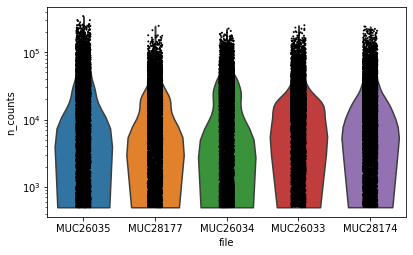

In [13]:
t1 = sc.pl.violin(adata, 'n_counts',
                  groupby='file',
                  size=2, log=True, cut=0)

In [14]:
# Load raw data
# List all files
file_name='raw_feature_bc_matrix.h5ad'
files=glob.glob(path_data+file_name)
# Find which parts of file paths differ between files to later use them as file id
diff_path_idx=[]
for position in range(len(path_data.split('/'))):
    values=set([file.split('/')[position] for file in files])
    if len(values)>1:
        diff_path_idx.append(position)

In [15]:
# Subset to files used for reference
files_subset=[]
for file in files:
    sample='_'.join([file.split('/')[i] for i in diff_path_idx])
    if any(sample_name in sample for sample_name in samples.sample_name.values):
        files_subset.append(file)
print('Selected sample files:')
print(files_subset)

Selected sample files:
['/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC26035/raw_feature_bc_matrix.h5ad', '/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC28177/raw_feature_bc_matrix.h5ad', '/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC26034/raw_feature_bc_matrix.h5ad', '/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC26033/raw_feature_bc_matrix.h5ad', '/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC28174/raw_feature_bc_matrix.h5ad']


In [16]:
# Load files and extract parts of file path that identifies the file, compared to other loaded files
adatas_raw=[]
file_diffs=[]
for file in files_subset:
    print('Reading file',file)
    adatas_raw.append(sc.read_h5ad(file))
    #adatas_raw.append(h.open_h5ad(file=file,unique_id2=UID2))
    file_diffs.append('_'.join([file.split('/')[i] for i in diff_path_idx]))
    
adata_raw = ann.AnnData.concatenate( *adatas_raw,  batch_key = 'file', batch_categories = file_diffs).copy()    

Reading file /storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC26035/raw_feature_bc_matrix.h5ad
Reading file /storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC28177/raw_feature_bc_matrix.h5ad
Reading file /storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC26034/raw_feature_bc_matrix.h5ad
Reading file /storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC26033/raw_feature_bc_matrix.h5ad
Reading file /storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/P21002/rev7/scanpy_AnnData/MUC28174/raw_feature_bc_matrix.h5ad


In [17]:
adata_raw

AnnData object with n_obs × n_vars = 33974400 × 20611
    obs: 'file'

In [18]:
# Add file annotation if single sample is present so that below code works
if len(file_diffs)==1:
    adata_raw.obs['file']=file_diffs[0]

In [ ]:
# Saved due to problems with loading files from h5ad
#pickle.dump( adata_raw, open( shared_folder+file_name.replace('.h5ad','_merged.pkl'), "wb" ) )

In [19]:
adata_raw.obs['n_counts'] = adata_raw.X.sum(1)

In [24]:
#adata_raw_temp=adata_raw.copy()

In [20]:
# Find drops removed by CellRanger
filtered_drops=~adata_raw.obs.index.isin(adata.obs.index)
print('N drops filtered out as empty:',filtered_drops.sum(),
      'out of all drops:',adata_raw.shape[0],'-> remaining:',adata.shape[0])

N drops filtered out as empty: 33933897 out of all drops: 33974400 -> remaining: 40503


Distribution of N counts of drops that were removed by CellRanger

Trying to set attribute `.uns` of view, copying.


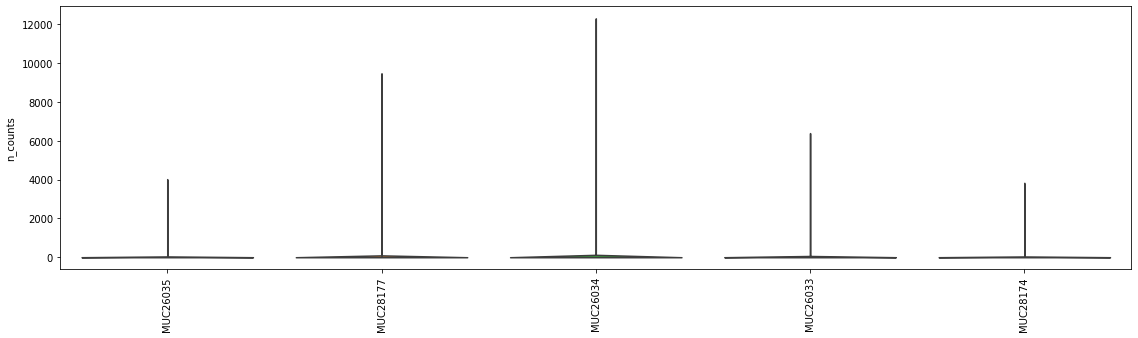

In [21]:
# Plot n_counts of drops that were removed by CellRanger
rcParams['figure.figsize']= (15,5)
sc.pl.violin(adata_raw[filtered_drops], ['n_counts'], groupby='file', size=1, log=False,rotation=90,stripplot=False)

In [27]:
#print('N cells per non-filtered sample')
#adata_raw.obs['file'].value_counts()

In [22]:
#Remove empty genes and cells
sc.pp.filter_cells(adata_raw, min_counts=1)
sc.pp.filter_genes(adata_raw, min_cells=1)

filtered out 22034322 cells that have less than 1 counts
filtered out 1648 genes that are detected in less than 1 cells


In [23]:
adata_raw

AnnData object with n_obs × n_vars = 11940078 × 18963
    obs: 'file', 'n_counts'
    var: 'n_cells'

For CellBender (NOT NEEDED): Cell N counts sorted by cell N counts rank without all 0 cells. 

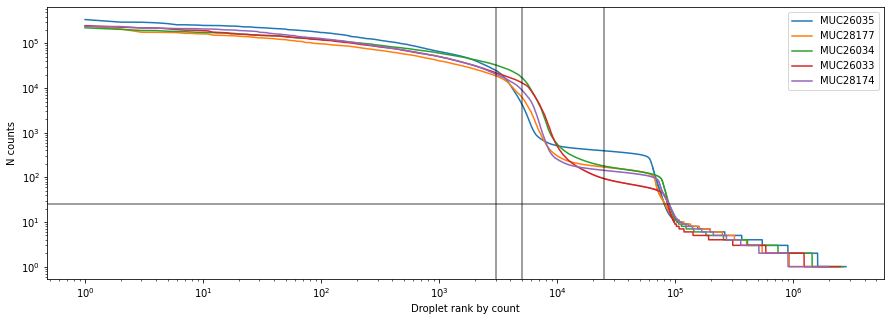

In [25]:
# For each file plot N count vs cell rank by count with log axes
fig, ax=plt.subplots()
for file in adata_raw.obs.file.unique():
    adata_raw_sub=adata_raw[adata_raw.obs.file==file,:].copy()
    plt.plot(list(range(1,adata_raw_sub.shape[0]+1)),adata_raw_sub.obs.n_counts.sort_values(ascending=False),
            label=file)
del adata_raw_sub
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Droplet rank by count')
plt.ylabel('N counts')
ax.axvline(3000,c='k',alpha=0.5)
ax.axvline(5000,c='k',alpha=0.5)
ax.axvline(25000,c='k',alpha=0.5)
ax.axhline(25,c='k',alpha=0.5)

## QC (counts, genes, mt)

In [65]:
# Add other QC metrics

#adata.obs['n_counts'] = adata.X.sum(axis = 1)
#adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

mt_gene_mask = np.flatnonzero([gene.startswith('MT-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']

### QC on UMAP 
Data used for UMAP: Total count normalised data with log transformation and PC preprocessing. UMAP distances are based on correlation.

In [59]:
# Preprocess data for UMAP
adata_pp=adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(adata_pp)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['CELA3B', 'CELA3A', 'S100A6', 'S100A2', 'G0S2', 'REG1B', 'REG1A', 'REG3A', 'ANKRD36C', 'GCG', 'CCL20', 'GHRL', 'MTRNR2L12', 'ARL14', 'SST', 'APOD', 'IGFBP7', 'CXCL8', 'CXCL1', 'CXCL5', 'CXCL2', 'SPP1', 'ESM1', 'SPINK1', 'SCGB3A1', 'IER3', 'HSPA1A', 'CLPS', 'SOD2', 'IL6', 'HSPB1', 'TFPI2', 'CPA1', 'PRSS1', 'PRSS2', 'TMSB4X', 'TIMP1', 'CCL21', 'HSPA5', 'RPL12', 'SETX', 'INS', 'CALCA', 'FTH1', 'MMP7', 'MMP1', 'CRYAB', 'VIM', 'RBP4', 'PNLIP', 'GAPDH', 'MGP', 'IGFBP6', 'PLA2G1B', 'UBC', 'RGCC', 'NFKBIA', 'SERPINA1', 'HSP90AA1', 'RPLP1', 'MT2A', 'MT1G', 'RRAD', 'CTRB2', 'CTRB1', 'PLCG2', 'CCL2', 'CCL3', 'PPY', 'H3-3B', 'TTR', 'PI3', 'GADD45B', 'FTL', 'MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4', 'MT-ND5', 'MT-CYB']
    finished (0:00:00)


computing PCA
    with n_comps=15
    finished (0:00:58)


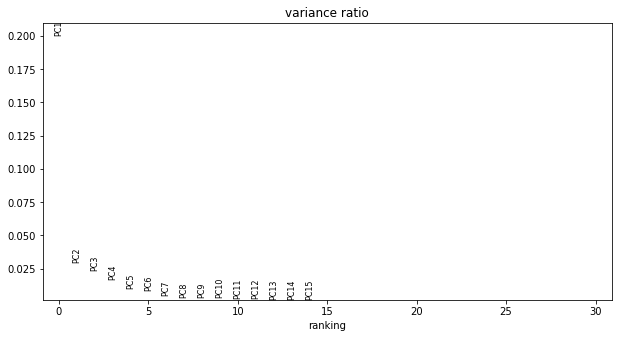

In [60]:
# Select number of PCs to use for UMAP
sc.pp.pca(adata_pp,n_comps=15,use_highly_variable =False)
sc.pl.pca_variance_ratio(adata_pp)

In [63]:
# Compute UMAP
sc.pp.neighbors(adata_pp, n_neighbors=15, n_pcs=6, metric='correlation')
sc.tl.umap(adata_pp)

computing neighbors
    using 'X_pca' with n_pcs = 6
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:32)


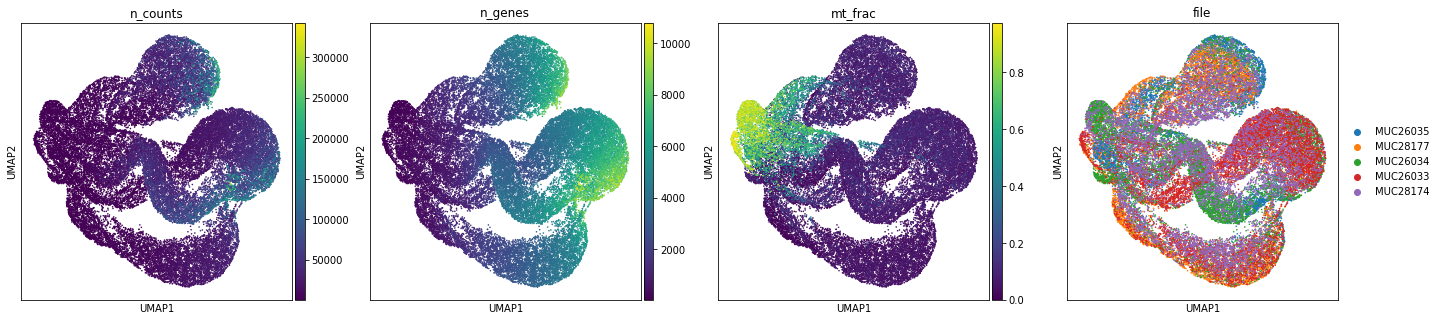

In [71]:
# Plot UMAP
rcParams['figure.figsize']=(5,5)
#TODO File was not plotted
sc.pl.umap(adata_pp, color=['n_counts','n_genes','mt_frac','file'],size=10)

#C: There is a subset of low counts and low genes cells that have high mt_fraction. Not all low count/gene cells have high mt fraction.

### QC - select thresholds

Check:
- joint distribution of N genes, N counts, and mt fraction
- distribution of metrics across samples

In [123]:
p11

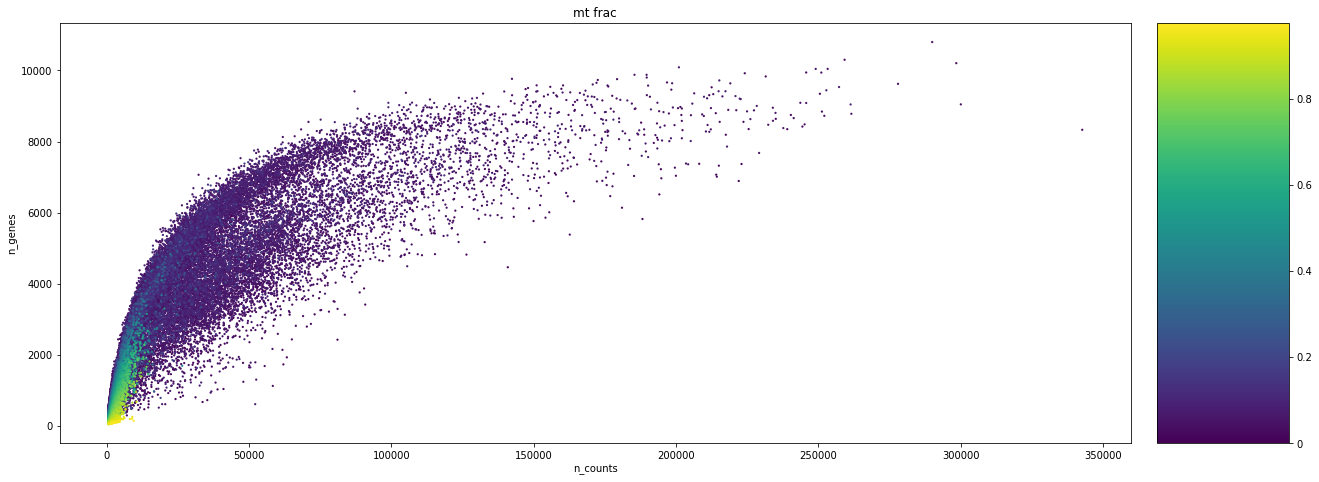

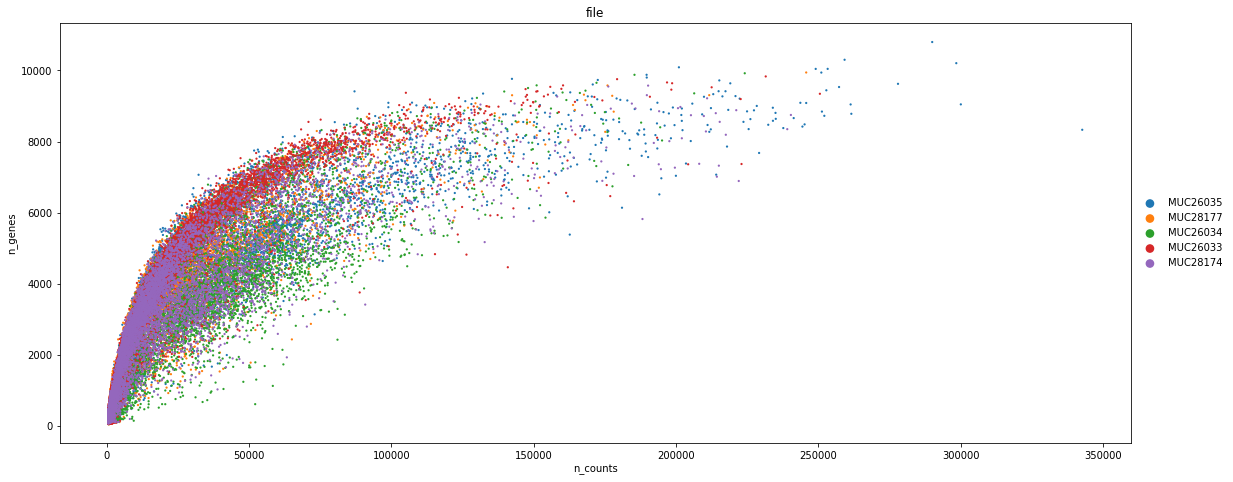

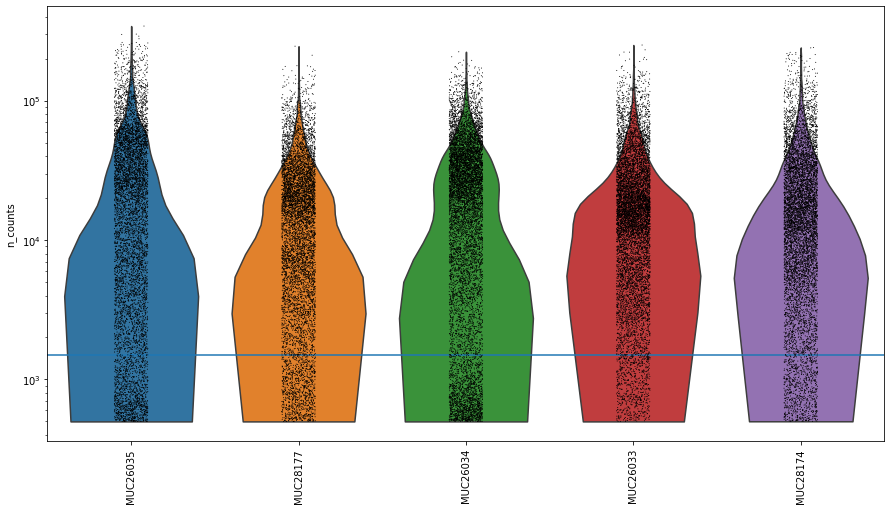

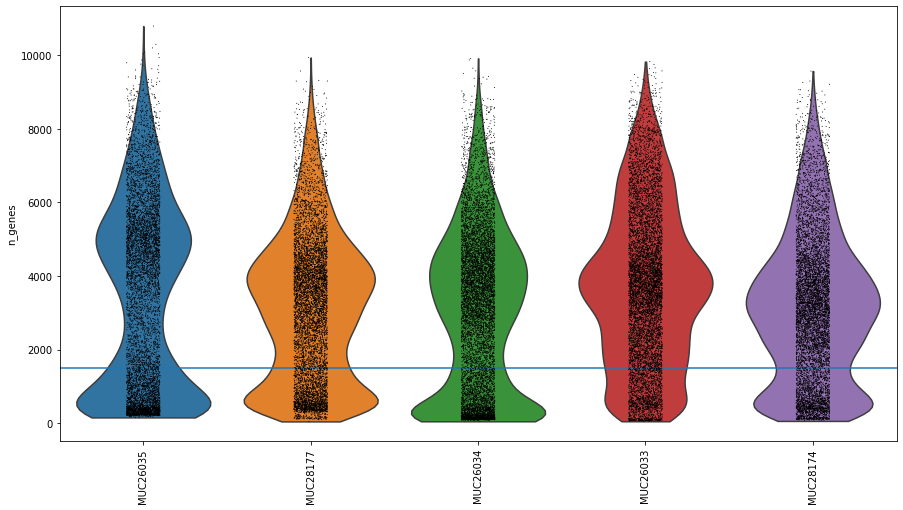

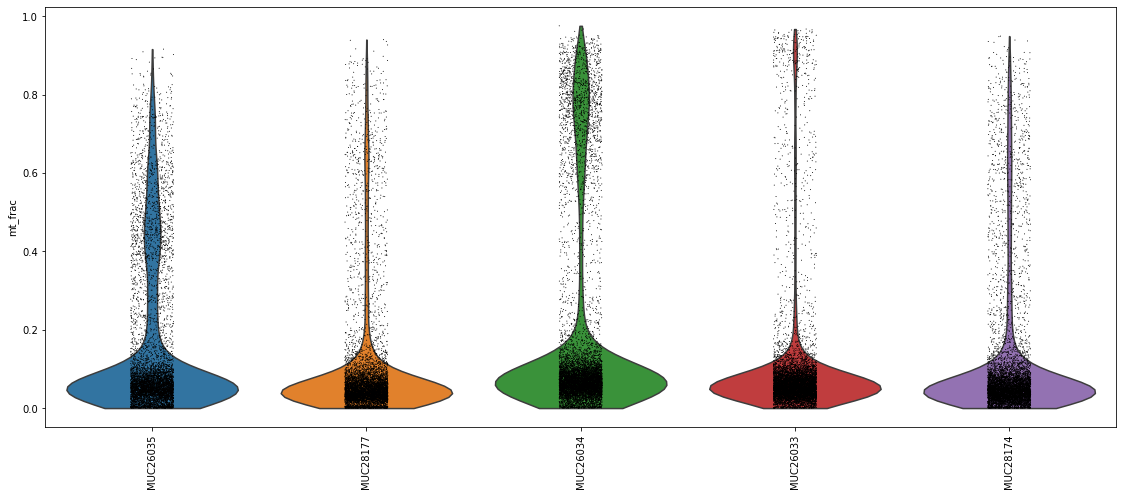

In [133]:
#Data quality summary plots
rcParams['figure.figsize']=(15,8)
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', size=20)
random_indices=np.random.permutation(list(range(adata.shape[0])))
p1 = sc.pl.scatter(adata[random_indices,:], 'n_counts', 'n_genes', color='file', size=20)
fig,ax=plt.subplots()
sc.pl.violin(adata, ['n_counts'], groupby='file', size=1, log=True,rotation=90,ax=ax,show=False)
ax.axhline(1500)
fig,ax=plt.subplots()
sc.pl.violin(adata, ['n_genes'], groupby='file', size=1, log=False,rotation=90,ax=ax,show=False)
ax.axhline(1500)
sc.pl.violin(adata, ['mt_frac'], groupby='file', size=1, log=False,rotation=90)

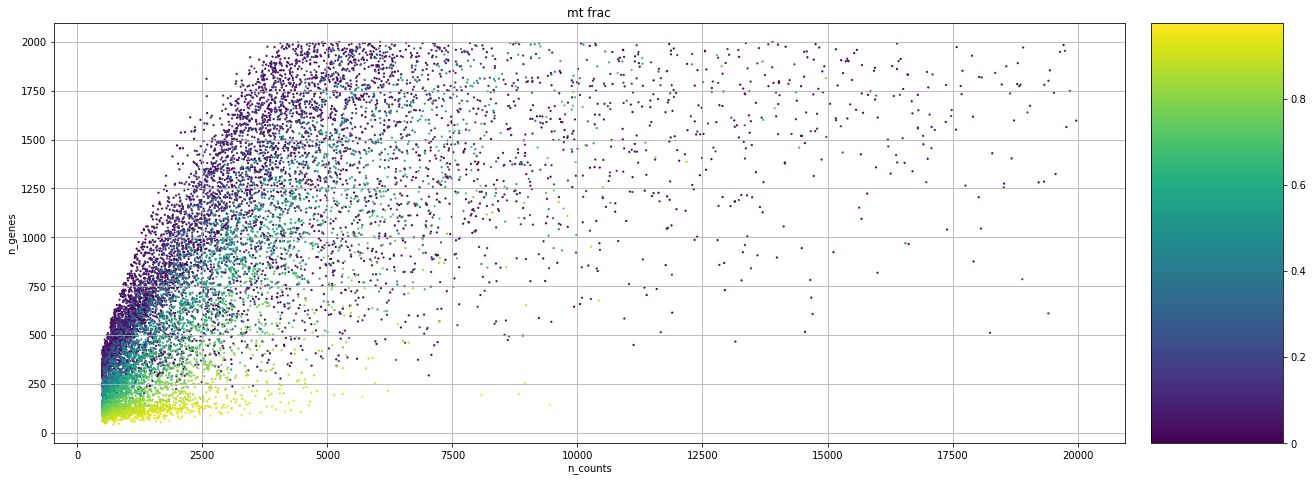

In [82]:
rcParams['figure.figsize']=(15,8)
p1 = sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<2000, adata.obs['n_counts']<20000)], 'n_counts', 'n_genes', color='mt_frac', size=20,show=False)
p1.grid()
plt.show()

N counts:

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

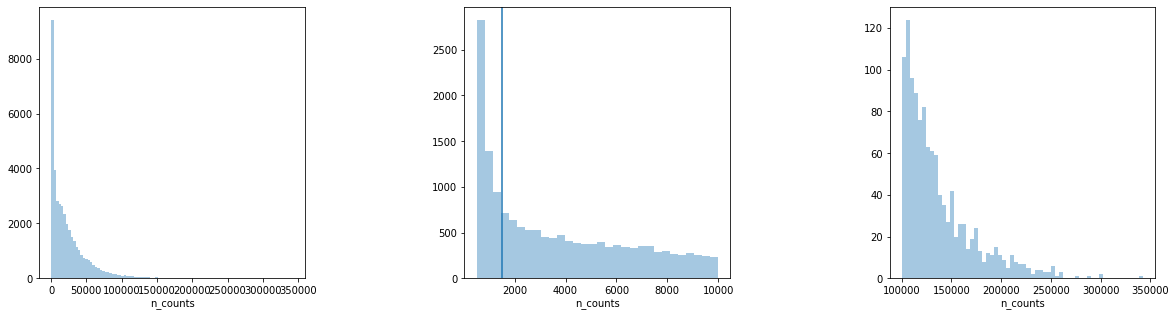

In [134]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata.obs['n_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]), bins=100)
#p3.set_xscale('log')
p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<10000], 
                 kde=False, bins=30, 
                 ax=fig.add_subplot(fig_ind[1]))
#p4.set_yscale('log')
p4.axvline(1500)
p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>100000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

N genes:

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


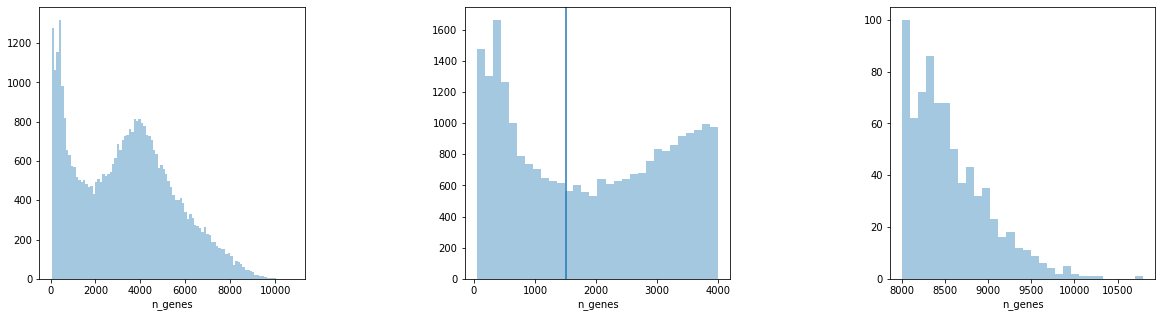

In [135]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=100, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<4000], 
                 kde=False, bins=30, ax=fig.add_subplot(fig_ind[1]))
p7.axvline(1500)
p8 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']>8000], 
                 kde=False, bins=30, ax=fig.add_subplot(fig_ind[2]))
plt.show()

MT fraction:

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


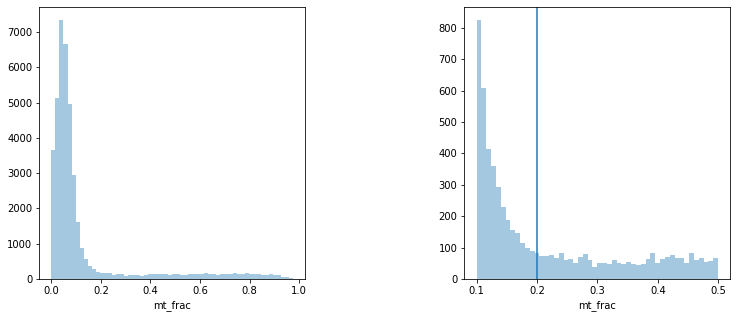

In [111]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.distplot(adata.obs['mt_frac'][(adata.obs['mt_frac']<0.5).values & \
                                      (adata.obs['mt_frac']>0.1).values], 
                 kde=False, bins=50, ax=fig.add_subplot(fig_ind[1]))
p9.axvline(0.2)
plt.show()

For cells that have too low/high metrics show location on UMAP.

In [86]:
def assign_high_low(adata,obs_col,low,high):
    """
    Add low/high annotation to each cell for a metric. 
    Add obs column specifying if cell has ok/low/high value (categories ordered in this order) and uns color map - 
    gray for ok, blue for low, red for high.
    New obs columns is named obs_col_filter and colourmap is named obs_col_filter_colors.
    :param adata: anndata object that contains column with metric to be filtered and to which filter result column
    and colur map are added
    :param obs_col: obs column on which to perform filtering
    :param low: low - cells that have obs_col value < low are assigned 'low'
    :param high: high - cells that have obs_col value > high are assigned 'high'
    """
    cell_type=[]
    for val in adata.obs[obs_col]:
        if val>high:
            cell_type.append('high')
        elif val<low:
            cell_type.append('low')
        else:
            cell_type.append('ok')
    adata.obs[obs_col+'_filter']=cell_type
    adata.obs[obs_col+'_filter']=adata.obs[obs_col+'_filter'].astype('category')
    # So that low and high are plotted on top
    adata.obs[obs_col+'_filter'].cat.reorder_categories(
        [category for category in ['ok','low','high'] if category in adata.obs[obs_col+'_filter'].cat.categories], inplace=True)
    type_col={'high':'#e62e0e','low':'#02c6ed','ok':'#a8a8a8'}
    col_list=[]
    for filter_type in adata.obs[obs_col+'_filter'].cat.categories:
        col_list.append(type_col[filter_type])
    adata.uns[obs_col+'_filter_colors']=col_list

In [ ]:
# Changed THR for n_counts, n_genes and mt_frac
# for value see section 136, 137, 138
#

ok      35231
low      5267
high        5
Name: n_counts_filter, dtype: int64


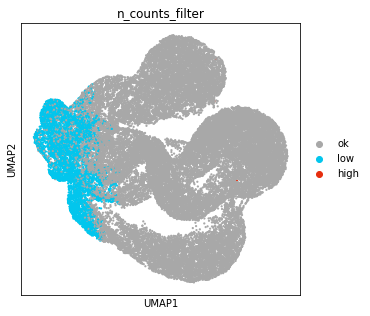

In [136]:
param='n_counts'
rcParams['figure.figsize']=(5,5)
# COUNTS_THR_MIN set from 1500 to 1000
# COUNTS_THR_MAX set from 27000 to 28000 , to see more, need to be adjust later
COUNTS_THR_MIN=1000
COUNTS_THR_MAX=280000
assign_high_low(adata=adata,obs_col=param,low=COUNTS_THR_MIN,high=COUNTS_THR_MAX)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=20)

ok      29646
low     10856
high        1
Name: n_genes_filter, dtype: int64


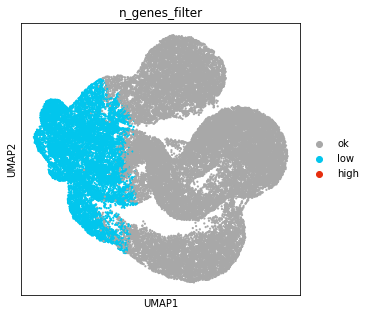

In [137]:
param='n_genes'
rcParams['figure.figsize']=(5,5)
# GENES_THR_MIN set from 1500 to 1000
# GENES_THR_MAX set from 10500 to 11000, to see more, need to be adjust later
GENES_THR_MIN=1000
GENES_THR_MAX=11000
assign_high_low(adata=adata,obs_col=param,low=GENES_THR_MIN,high=GENES_THR_MAX)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=20)

ok      34599
high     5904
Name: mt_frac_filter, dtype: int64


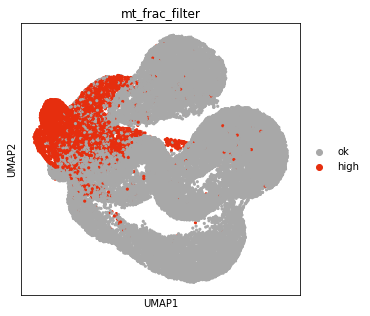

In [115]:
# Set MT_THR from 0.2 to 0.25 
param='mt_frac'
MT_THR=0.25
rcParams['figure.figsize']=(5,5)
assign_high_low(adata=adata,obs_col=param,low=-1,high=MT_THR)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=40)

#C: High N cells and N gene outliers will be filtered out as well. Min counts will not be used for filtering as it is unclear where to put a threshold - mt and gene filtering will as it seems also remove these cells. 

N cells in which a gene is expressed:

In [116]:
adata.var['n_cells']=(adata.X > 0).sum(axis = 0).T

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


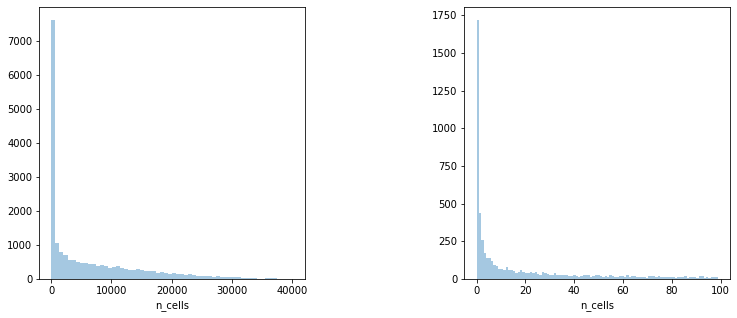

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='n_cells'>

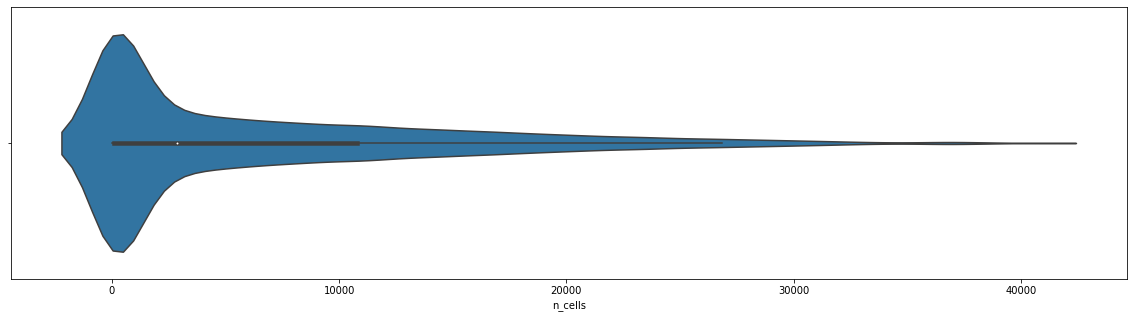

In [117]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.var['n_cells'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p8 = sb.distplot(adata.var['n_cells'][adata.var['n_cells']<100], 
                 kde=False, bins=100, ax=fig.add_subplot(fig_ind[1]))
plt.show()
sb.violinplot(adata.var['n_cells'] )

Filter out genes and cells

In [138]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = COUNTS_THR_MIN)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_counts = COUNTS_THR_MAX)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] <= MT_THR]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = GENES_THR_MIN)
print('Number of cells after min gene filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_genes = GENES_THR_MAX)
print('Number of cells after max gene filter: {:d}'.format(adata.n_obs))

filtered out 5267 cells that have less than 1500 counts


Total number of cells: 40503


filtered out 5 cells that have more than 270000 counts


Number of cells after min count filter: 35236
Number of cells after max count filter: 35231
Number of cells after MT filter: 31807


filtered out 3043 cells that have less than 1500 genes expressed
Trying to set attribute `.obs` of view, copying.


Number of cells after min gene filter: 28764
Number of cells after max gene filter: 28764


In [139]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

CELLS_THR_MIN=20
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=CELLS_THR_MIN)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 20611


filtered out 3928 genes that are detected in less than 20 cells


Number of genes after cell filter: 16683


Subset genes so that ref genes are not removed - UNUSED - insetad of the above cell

In [35]:
#adata_temp=adata.copy()

## Doublet filtering

Perform doublet filtering with Scrublet per sample.

In [140]:
adata.obs['doublet_score']=np.zeros(adata.shape[0])
adata.obs['doublet']=np.zeros(adata.shape[0])

# filtering/preprocessing parameters:
min_counts = 3
min_cells = 3
vscore_percentile = 85
n_pc = 30

# doublet detector parameters:
expected_doublet_rate = 0.05 
sim_doublet_ratio = 2
n_neighbors = None #If `None`, this is set to round(0.5 * sqrt(n_cells))

# Detect doublets per sample
for batch in adata.obs['file'].cat.categories:
    idx = adata.obs[adata.obs['file']==batch].index
    print(batch, 'N cells:',idx.shape[0])
    scrub = scr.Scrublet(counts_matrix = adata[idx,:].X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)
    adata.obs.loc[idx,'doublet_score'] = doublet_scores
    adata.obs.loc[idx,'doublet'] = predicted_doublets

MUC26035 N cells: 4297
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.21
Detected doublet rate = 3.1%
Estimated detectable doublet fraction = 38.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.0%
Elapsed time: 13.6 seconds
MUC28177 N cells: 5285
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.19
Detected doublet rate = 3.5%
Estimated detectable doublet fraction = 43.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.0%
Elapsed time: 7.5 seconds
MUC26034 N cells: 6167
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.15
Detected doublet rate = 7.1%
Estimated detectable doublet fraction = 48.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  

Distribution of doublet scores

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


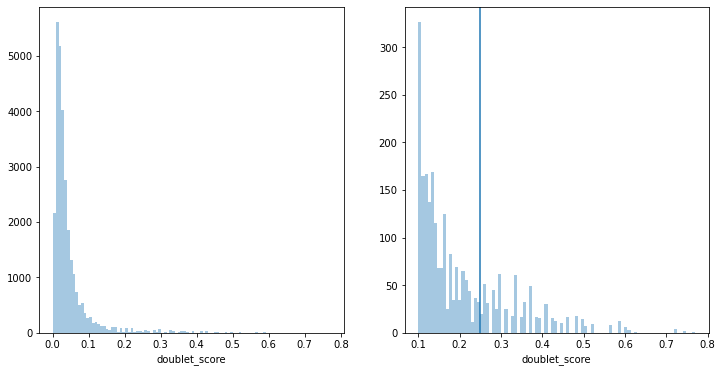

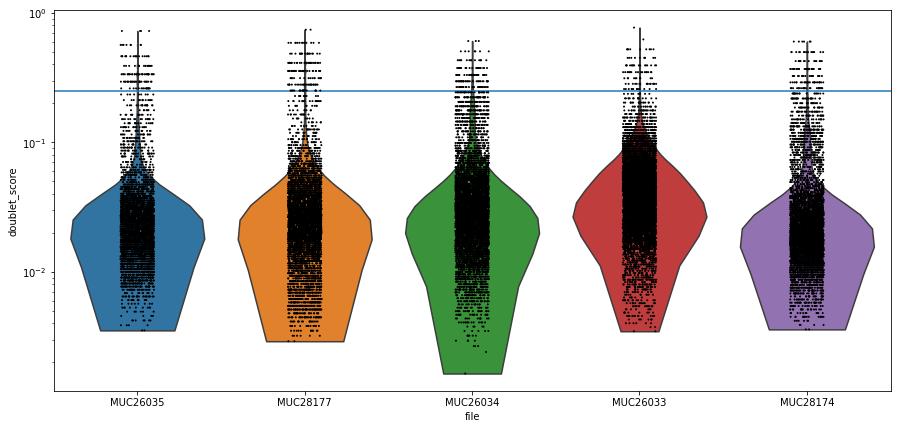

In [145]:
rcParams['figure.figsize']=(12,6)
fig,ax=plt.subplots(1,2)
sb.distplot(adata.obs['doublet_score'], bins=100, kde=False,ax=ax[0])
sb.distplot(adata[adata.obs.doublet_score>0.1].obs['doublet_score'], bins=90, kde=False,ax=ax[1])
DOUBLET_THR=0.25
ax[1].axvline(DOUBLET_THR)
plt.show()

rcParams['figure.figsize']=(15,7)
fig,ax=plt.subplots()
sc.pl.violin(adata, 'doublet_score',
                  groupby='file',
                  size=2, log=True, cut=0,ax=ax,show=False)
ax.axhline(DOUBLET_THR)
plt.show()

Trying to set attribute `.obs` of view, copying.


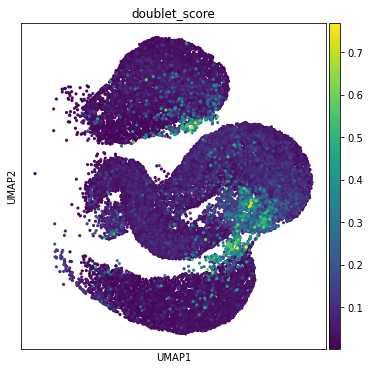

ok      28122
high      642
Name: doublet_score_filter, dtype: int64


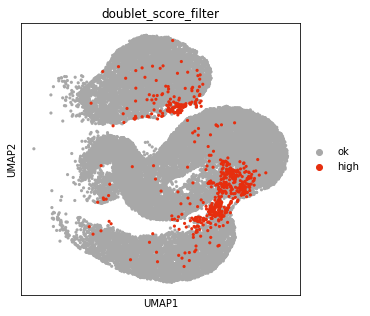

In [143]:
# Remove cells from adata_pp that were removed before from adata
adata_pp=adata_pp[adata.obs.index]

# Plot doublet score and filtering threshold on UMAP
rcParams['figure.figsize']=(6,6)
adata_pp.obs['doublet_score']=adata.obs['doublet_score']
sc.pl.umap(adata_pp, color=['doublet_score'],size=40)
param='doublet_score'
rcParams['figure.figsize']=(5,5)
assign_high_low(adata=adata,obs_col=param,low=-np.inf,high=DOUBLET_THR)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp[adata_pp.obs[param+'_filter'].sort_values().index], color=[param+'_filter'],size=40)

In [146]:
print('Number of cells before doublet filter: {:d}'.format(adata.n_obs))
idx_filt = adata.obs['doublet_score']<=DOUBLET_THR

adata = adata[idx_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

Number of cells before doublet filter: 28764
Number of cells after doublet filter: 28122


## Summary after QC

In [147]:
# Summary statistics per file/batch
df = adata.obs[['n_genes','n_counts','file']]
df_all = pd.DataFrame(index=df['file'].unique())

df_all['mean_genes']=df.groupby(by='file')['n_genes'].mean()
df_all['median_genes']=df.groupby(by='file')['n_genes'].median()
df_all['mean_counts']=df.groupby(by='file')['n_counts'].mean()
df_all['median_counts']=df.groupby(by='file')['n_counts'].median()
df_all['n_cells']=df['file'].value_counts()
df_all.astype('float').round(1)

mean_genes  median_genes  mean_counts  median_counts  n_cells
MUC26035      5078.5        5035.0      48137.7        37150.0   4174.0
MUC28177      4044.4        3916.0      26946.9        20633.0   5128.0
MUC26034      4242.6        4094.5      37767.5        31567.5   6030.0
MUC26033      4399.3        4110.0      27493.3        18733.0   7045.0
MUC28174      3935.2        3630.0      30410.0        20524.0   5745.0

In [148]:
# Check that all filters were used properly - the min/max values are as expected
print('N counts range:',round(adata.obs['n_counts'].min(),1),'-',round(adata.obs['n_counts'].max(),1))
print('N genes range:',adata.obs['n_genes'].min(),'-',adata.obs['n_genes'].max())
print('Mt fraction range:',"{:.3e}".format(adata.obs['mt_frac'].min()),'-',"{:.3e}".format(adata.obs['mt_frac'].max()))
print('Doublet score range:',"{:.3e}".format(adata.obs['doublet_score'].min()),'-',"{:.3e}".format(adata.obs['doublet_score'].max()))
print('N cellls expressing a gene range:',adata.var['n_cells'].min(),'-',adata.var['n_cells'].max())

N counts range: 2072.0 - 261601.0
N genes range: 1500 - 10044
Mt fraction range: 0.000e+00 - 1.997e-01
Doublet score range: 1.642e-03 - 2.434e-01
N cellls expressing a gene range: 20 - 28760


## Save QC data

In [149]:
# Save QC data
adata.write(shared_folder+'data_QC.h5ad')
#h.save_h5ad(adata=adata,file=shared_folder+'data_QC.h5ad',unique_id2=UID2)
#pickle.dump( adata, open( shared_folder+"data_QC.pkl", "wb" ) )

## Normalisation and log-scaling

In [70]:
# Load QC data
adata=sc.read_h5ad(shared_folder+'data_QC.h5ad')
#adata=pickle.load( open( shared_folder+"data_QC.pkl", "rb" ) )
#adata=h.open_h5ad(file=shared_folder+'data_QC.h5ad',unique_id2=UID2)

In [150]:
# Remove ambient genes from analysis - required if joint normalisation is performed
print('Number of genes: {:d}'.format(adata.var.shape[0]))
ambient_genes=pickle.load( open( shared_folder+"ambient_genes_selection.pkl", "rb" ) )
# Save all genes to raw
adata.raw=adata.copy()
adata = adata[:,np.invert(np.in1d(adata.var_names, ambient_genes))].copy()
print('Number of genes after ambient removal: {:d}'.format(adata.var.shape[0]))

Number of genes: 16683
Number of genes after ambient removal: 16653


In [151]:
adata.layers['counts'] = adata.X.copy()

In [152]:
# Data for: clustering for scran normalization in clusters and visualisation of samples on UMAP
# Make new adata_pp object that also has removed unexpressed genes 
# The adata_pp is pre-processed with normalisation to N total counts, log transformation and PC dimeni
adata_pp=adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['AMY2A', 'S100A6', 'S100A2', 'HSPA6', 'G0S2', 'REG3A', 'IL1B', 'GCG', 'CCL20', 'GHRL', 'CPB1', 'CXCL8', 'CXCL1', 'CXCL5', 'CXCL3', 'CXCL2', 'SCGB3A1', 'IER3', 'HSPA1A', 'SOD2', 'ACTB', 'IL6', 'TFPI2', 'TMSB4X', 'TIMP1', 'PRSS3', 'TXN', 'HSPA5', 'CEL', 'CALCA', 'C11orf96', 'MMP7', 'MMP1', 'CRYAB', 'VIM', 'RBP4', 'PNLIP', 'GAPDH', 'IAPP', 'IGFBP6', 'RGCC', 'NFKBIA', 'HSP90AA1', 'MT2A', 'MT1E', 'MT1G', 'MT1X', 'RRAD', 'CCL2', 'CCL3', 'PPY', 'H3-3B', 'ACTG1', 'PI3', 'GADD45B', 'SYCN']
    finished (0:00:02)
computing PCA
    with n_comps=15
    finished (0:00:32)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)


Cluster cells for scran normalisation

In [153]:
# Perform clustering
sc.tl.leiden(adata_pp, key_added='groups', resolution=1)
print('N clusters:',adata_pp.obs['groups'].unique().shape[0])

running Leiden clustering
    finished: found 22 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:09)


N clusters: 22


Compare samples on UMAP before scran normalisation to decide if it can be peroformed jointly or not.

In [154]:
# Calculate UMAP
sc.tl.umap(adata_pp)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)


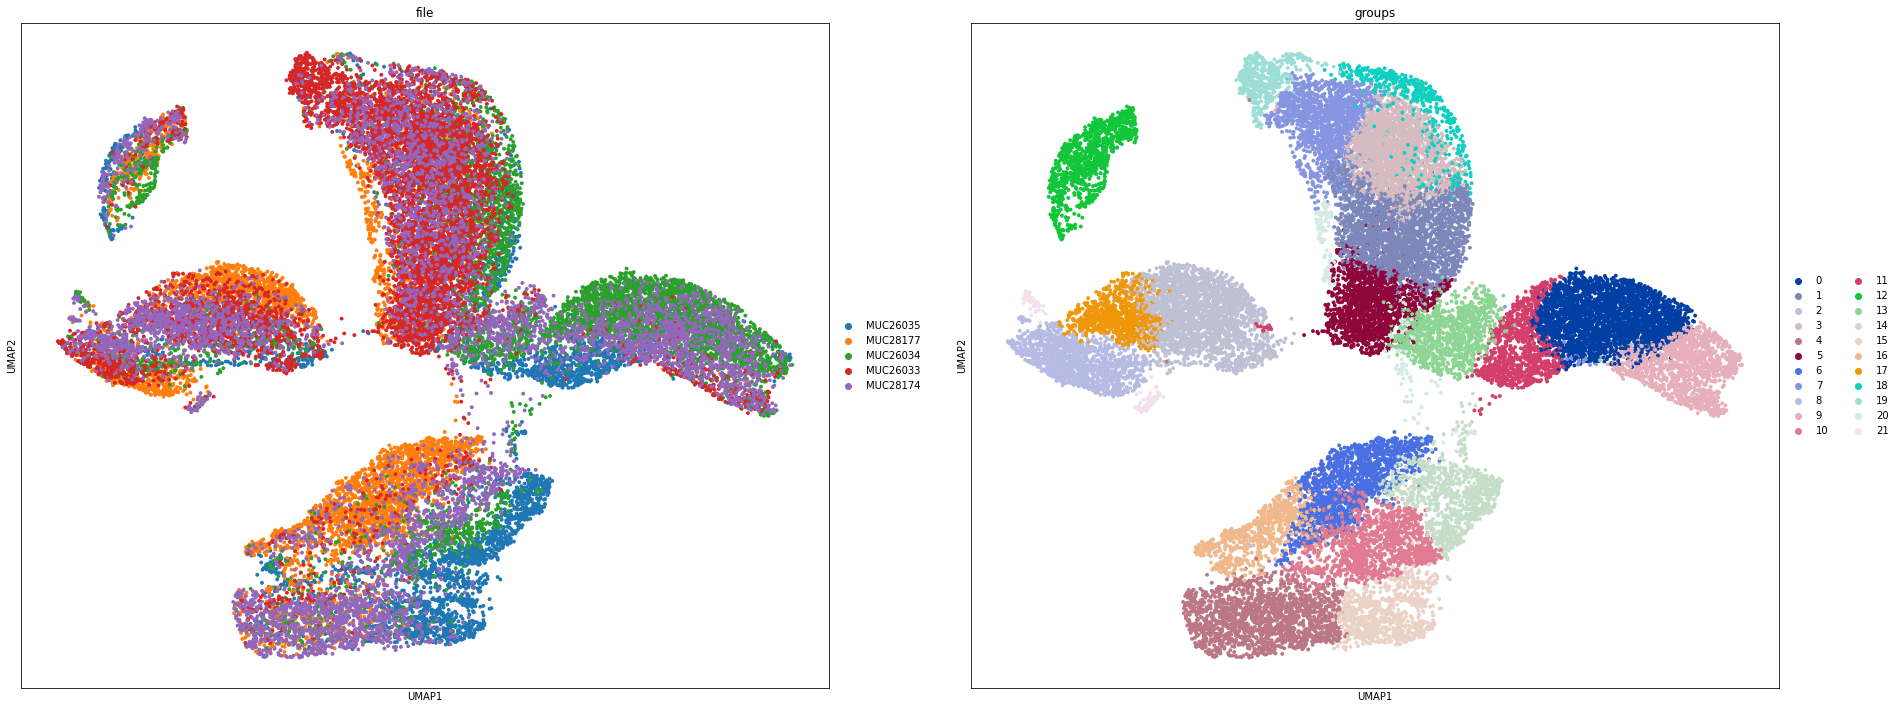

In [155]:
# Plot UMAP
rcParams['figure.figsize']=(15,12)
sc.pl.umap(adata_pp, color=['file','groups'],size=60)

Joint Scran normalisation

In [156]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [157]:
%%R -i data_mat -i input_groups -o size_factors
size_factors =  calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1,BPPARAM=MulticoreParam(workers = 8))

Distribution of size factors

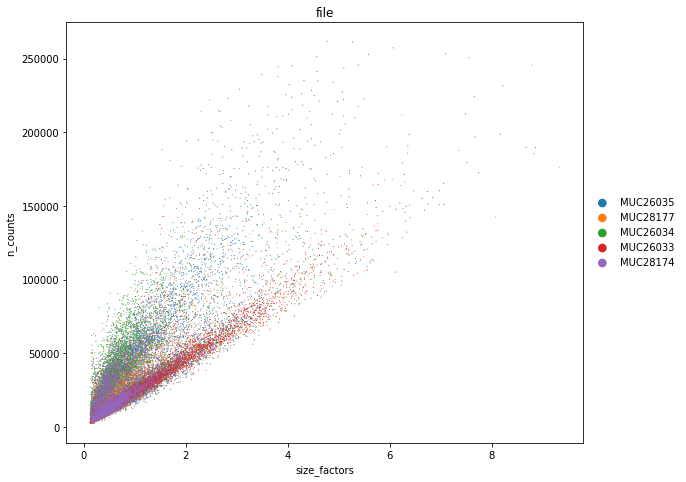

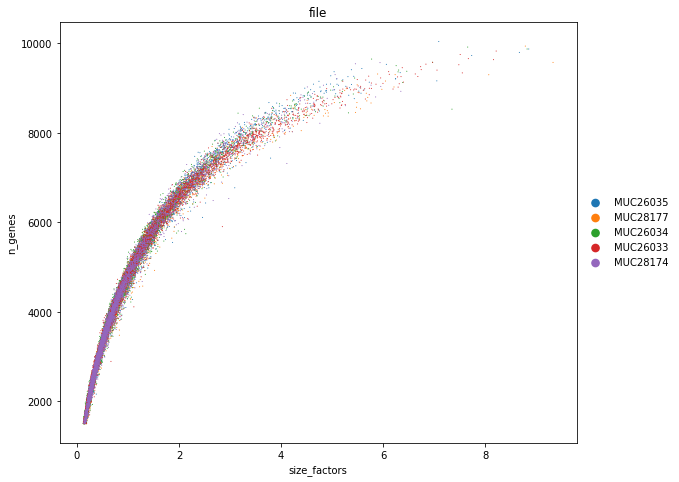

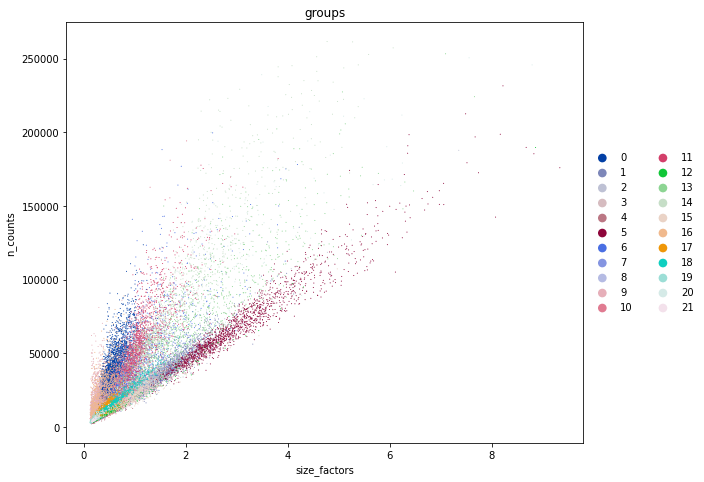

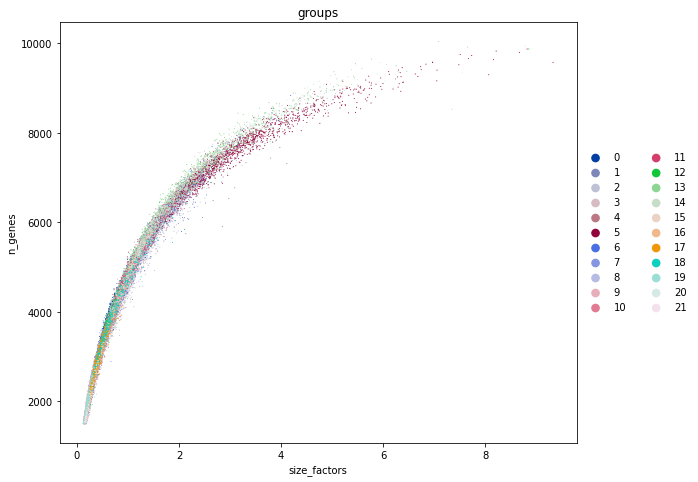

Distribution of size factors


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


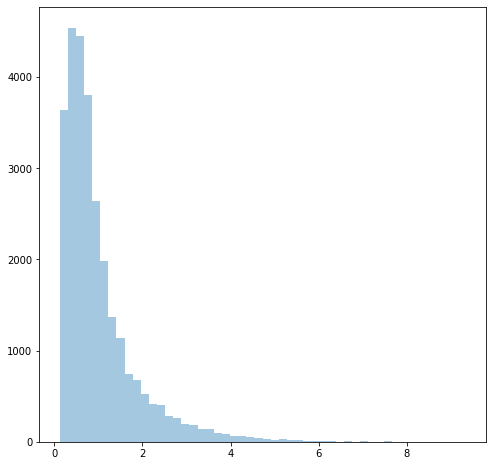

In [158]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors
adata_pp.obs['size_factors'] = size_factors

rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata, 'size_factors', 'n_counts', color='file')
sc.pl.scatter(adata, 'size_factors', 'n_genes', color='file')

#let us visualise how size factors differ across clusters
rcParams['figure.figsize']=(8,8)
#Use adata_pp here as it has obs 'group' - the n_genes and n_counts were copied from andata (counts/not normalised)
sc.pl.scatter(adata_pp, 'size_factors', 'n_counts', color='groups')
sc.pl.scatter(adata_pp, 'size_factors', 'n_genes', color='groups')

print('Distribution of size factors')
sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [159]:
# Scale data with size factors
adata.X /= adata.obs['size_factors'].values[:,None] # This reshapes the size-factors array
sc.pp.log1p(adata)
adata.X = np.asarray(adata.X)

In [160]:
del adata_pp

## Highly variable genes

Compare Seurat and CellRanger HVGs.

In [82]:
##hvg_vars=['highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection']

## Seurat
#sc.pp.highly_variable_genes(adata, flavor='seurat', batch_key='file')
#n_hvg_seurat=np.sum(adata.var['highly_variable'])
#print('\n','Number of highly variable genes: {:d}'.format(n_hvg_seurat))
##hvg_seurat=adata.var[hvg_vars]
#rcParams['figure.figsize']=(10,5)
#sc.pl.highly_variable_genes(adata)

## Same number of genes in CellRanger
#sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='file',n_top_genes =n_hvg_seurat)
#print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
##hvg_cellranger=adata.var[hvg_vars]
#rcParams['figure.figsize']=(10,5)
#sc.pl.highly_variable_genes(adata)

#C: Decided for CellRanger method.

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
    finished (0:01:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)



 Number of highly variable genes: 2000


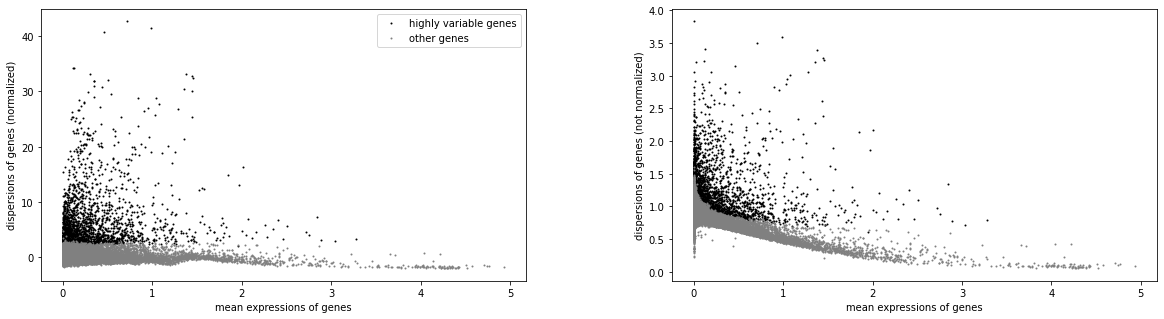

In [161]:
# Compute and plot HVG
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='file',n_top_genes =2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

In [162]:
adata

AnnData object with n_obs × n_vars = 28122 × 16653
    obs: 'file', 'n_counts', 'n_genes', 'mt_frac', 'n_counts_filter', 'n_genes_filter', 'mt_frac_filter', 'doublet_score', 'doublet', 'doublet_score_filter', 'size_factors'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'file_colors', 'n_counts_filter_colors', 'n_genes_filter_colors', 'mt_frac_filter_colors', 'doublet_score_filter_colors', 'log1p', 'hvg'
    layers: 'counts'

## Save normalised data

In [85]:
# Used due to problems with saving h5ad
#pickle.dump( adata, open( shared_folder+"data_normalised.pkl", "wb" ) )

In [163]:
adata.write(shared_folder+"data_normalised.h5ad")
#h.save_h5ad(adata=adata, file=shared_folder+"data_normalised.h5ad",unique_id2=UID2)

In [107]:
#adata_temp=adata.copy()
#adata=adata_temp.copy()

In [108]:
#adata_temp.write('/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/salinno_project/rev4/scanpy_AnnData/data_processed_temp.h5ad')